In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ISHANT KUNDRA 
CSCE 633 ML 

# PART  A - Data Pre-Processing:

In [2]:
import pandas as pd
import nltk
import re

# Function to download necessary NLTK resources
def download_nltk_resources():
    nltk.download('stopwords')
    nltk.download('punkt')

# Call the function to ensure resources are available
download_nltk_resources()

from nltk.corpus import stopwords

# Define the stopwords set outside the function to improve efficiency
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation, exclude underscores
    words = nltk.word_tokenize(text)  # Tokenize the text
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)  # Join the words back into a string

# Function to convert stars to sentiment
def convert_to_sentiment_category(stars):
    if stars > 3:
        return 'Positive'
    elif stars == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Function to load data and apply preprocessing
def preprocess_data(file_path):
    try:
        data = pd.read_csv(file_path)
        data['processed_text'] = data['text'].apply(preprocess_text)
        data['sentiment'] = data['stars'].apply(convert_to_sentiment_category)
        return data
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Process train and test data
train_data = preprocess_data('yelp_review_train.csv')
test_data = preprocess_data('yelp_review_test.csv')

# Save the preprocessed datasets to new CSV files, if data is not None
if train_data is not None:
    train_data.to_csv('train_yelp_review_preprocessed.csv', index=False)

if test_data is not None:
    test_data.to_csv('test_yelp_review_preprocessed.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# PART B - Input Data Preparation:

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

# Combine training and testing data to build a unified vocabulary
all_data = pd.concat([train_data, test_data])

# Initialize the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data['processed_text'])  # Create vocabulary from the preprocessed text

# Determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['processed_text'])

# Define a fixed sequence length and pad sequences to this length
max_length = 100  # The fixed length for all sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Map sentiment categories to numerical values
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_labels = train_data['sentiment'].map(sentiment_mapping)
test_labels = test_data['sentiment'].map(sentiment_mapping)

# Save the padded sequences, labels, and tokenizer for further use
pd.DataFrame(train_padded).to_csv('train_padded.csv', index=False)
pd.DataFrame(test_padded).to_csv('test_padded.csv', index=False)
pd.DataFrame(train_labels).to_csv('train_labels.csv', index=False)
pd.DataFrame(test_labels).to_csv('test_labels.csv', index=False)

# Save tokenizer configuration as a JSON file
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)


# PART C -  Transformer Implementation:

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, MultiHeadAttention, LayerNormalization, Add, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Model parameters
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (total number of unique tokens)
embed_dim = 64  # Dimension of word embeddings
num_heads = 8  # Number of attention heads in the MultiHeadAttention layer
ffn_units = 32  # Number of units in the feed-forward network within transformer block
max_length = 100  # Fixed length of input sequences
dropout_rate = 0.6  # Dropout rate for regularization
l2_reg = 1e-4  # L2 regularization factor

# Transformer block function
def transformer_block(inputs, embed_dim, num_heads, ffn_units, dropout=0.1):
    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)  # Apply dropout for regularization
    out1 = Add()([inputs, attention_output])  # Add skip connection (residual)
    out1 = LayerNormalization(epsilon=1e-6)(out1)  # Apply layer normalization

    # Feed-forward network
    ffn_output = Conv1D(filters=ffn_units, kernel_size=1, activation="relu")(out1)  # First layer of FFN
    ffn_output = Dropout(dropout)(ffn_output)  # Apply dropout for regularization
    ffn_output = Conv1D(filters=embed_dim, kernel_size=1)(ffn_output)  # Second layer of FFN
    return Add()([out1, ffn_output])  # Add skip connection (residual)

# Build the model
inputs = Input(shape=(max_length,))  # Input layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)  # Word embedding layer
positional_encoding = Embedding(input_dim=max_length, output_dim=embed_dim)(inputs)  # Positional encoding layer
x = Add()([embedding_layer, positional_encoding])  # Combine word embeddings with positional encodings

# Stack multiple transformer blocks
num_transformer_blocks = 3  # Number of transformer blocks
for _ in range(num_transformer_blocks):
    x = transformer_block(x, embed_dim, num_heads, ffn_units)  # Apply transformer block

# Classification head
x = GlobalAveragePooling1D()(x)  # Apply global average pooling
x = Dense(32, activation="relu", kernel_regularizer=l2(l2_reg))(x)  # Dense layer with L2 regularization
x = Dropout(dropout_rate)(x)  # Apply dropout for regularization
outputs = Dense(3, activation="softmax")(x)  # Output layer with softmax for 3-class classification

# Finalize the model
model = Model(inputs=inputs, outputs=outputs)  # Create the model object


# PART D - Model Training:

In [5]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd

# Load preprocessed data
train_padded = pd.read_csv('train_padded.csv').values  # Load padded training data
train_labels = pd.read_csv('train_labels.csv').values  # Load training labels

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.1, random_state=42)  # 10% data for validation

# Define the ModelCheckpoint callback to save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    'best_model_full.h5',  # Filename to save the model
    save_best_only=True,   # Save only when 'val_loss' has improved
    monitor='val_loss',    # Monitor 'val_loss' for improvements
    mode='min'             # 'min' mode means the training will save the model when the quantity monitored has decreased.
)

# Compile the model with SGD optimizer with added gradient clipping
model.compile(
    optimizer=SGD(learning_rate=0.005, momentum=0.9, nesterov=True, clipvalue=1.0),  # Configure optimizer
    loss="sparse_categorical_crossentropy",  # Loss function suitable for multi-class classification
    metrics=["accuracy"]  # Metric to monitor
)

# Define ReduceLROnPlateau to reduce learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor 'val_loss' for learning rate reduction
    factor=0.1,          # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2           # Number of epochs with no improvement after which learning rate will be reduced.
)

# Define EarlyStopping to stop training early if no improvement is seen in validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor 'val_loss' for early stopping
    patience=4,                 # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    epochs=20,  # Number of epochs to train for
    batch_size=64,  # Size of the batches of data
    validation_data=(X_val, y_val),  # Validation data to evaluate the loss and any model metrics at the end of each epoch
    callbacks=[lr_scheduler, model_checkpoint, early_stopping]  # List of callbacks to apply during training
)

# Optionally print training progress
for key in history.history.keys():
    print(f"{key}: {history.history[key][-1]}")  # Print the last recorded value for each metric


Epoch 1/20
2458/2458 [==============================] - ETA: 0s - loss: 0.8338 - accuracy: 0.6704

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2458/2458 [==============================] - 204s 75ms/step - loss: 0.8338 - accuracy: 0.6704 - val_loss: 0.8260 - val_accuracy: 0.6669 - lr: 0.0050
Epoch 2/20
2458/2458 [==============================] - 94s 38ms/step - loss: 0.7566 - accuracy: 0.6988 - val_loss: 0.6444 - val_accuracy: 0.7658 - lr: 0.0050
Epoch 3/20
2458/2458 [==============================] - 93s 38ms/step - loss: 0.5092 - accuracy: 0.8171 - val_loss: 0.4525 - val_accuracy: 0.8341 - lr: 0.0050
Epoch 4/20
2458/2458 [==============================] - 87s 35ms/step - loss: 0.4642 - accuracy: 0.8385 - val_loss: 0.4268 - val_accuracy: 0.8400 - lr: 0.0050
Epoch 5/20
2458/2458 [==============================] - 83s 34ms/step - loss: 0.4410 - accuracy: 0.8448 - val_loss: 0.4880 - val_accuracy: 0.8123 - lr: 0.0050
Epoch 6/20
2458/2458 [==============================] - 88s 36ms/step - loss: 0.4238 - accuracy: 0.8492 - val_loss: 0.4068 - val_accuracy: 0.8468 - lr: 0.0050
Epoch 7/20
2458/2458 [==============================] - 

# PART E - Result analysis:

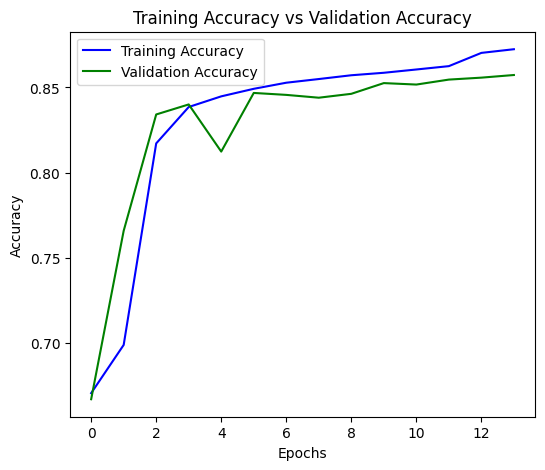

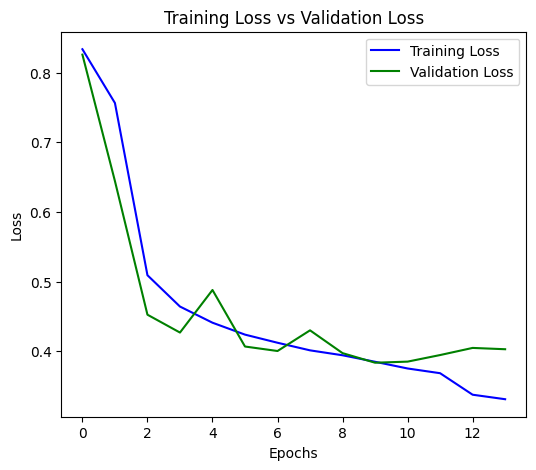

437/437 [==============================] - 4s 8ms/step - loss: 0.3896 - accuracy: 0.8515
Test Accuracy: 0.8515021204948425
437/437 [==============================] - 3s 6ms/step
Test Accuracy (calculated): 0.8515021459227468


In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.metrics import accuracy_score

# Plotting validation accuracy vs training accuracy
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')  # Plot validation accuracy
plt.title('Training Accuracy vs Validation Accuracy')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

# Plotting validation loss vs training loss
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')  # Plot validation loss
plt.title('Training Loss vs Validation Loss')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot


# Load the best model
model = tf.keras.models.load_model('best_model_full.h5')  # Load the saved model

# Load test data
test_padded = pd.read_csv('test_padded.csv').values  # Load padded test data
test_labels = pd.read_csv('test_labels.csv').values  # Load test labels

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)  # Evaluate model performance on test data
print(f"Test Accuracy: {test_accuracy}")  # Print test accuracy

# Optional: Calculate accuracy using sklearn for a more detailed analysis
predictions = model.predict(test_padded)  # Generate predictions for test data
predicted_classes = predictions.argmax(axis=-1)  # Determine the class with the highest probability

# Calculate accuracy using sklearn's accuracy_score function
accuracy = accuracy_score(test_labels, predicted_classes)
print(f"Test Accuracy (calculated): {accuracy}")  # Print the calculated test accuracy


In the code, I have set the hidden dimension size, or `embed_dim`, to 64. This size is a critical hyperparameter that defines the capacity of the model to capture the semantic details of the dataset. A moderate size like 64 is a balanced choice that aims to capture enough complexity without making the model excessively large.

For the number of attention layers, represented by `num_transformer_blocks`, I have chosen to use 3 transformer blocks. This number determines how many times the model will refine its attention across the sequence, essentially allowing it to build a more nuanced understanding of the relationships between words.

From the outputs I've generated, particularly the accuracy and loss graphs, it appears that I have managed to train a model that fits the training data well, achieving a training accuracy of approximately 87.24%. The validation accuracy is slightly lower at about 85.73%, which is a typical scenario indicating that the model may be beginning to overfit. However, the difference is not substantial, suggesting that the model generalizes reasonably well.

The loss graphs show a similar trend, with training loss decreasing to around 0.331 and validation loss being slightly higher at around 0.403. The slight divergence between training and validation performance could be an indication that the model's capacity is slightly more than what the data requires, or it could simply be a reflection of natural variations in the data.

I have implemented early stopping with a patience of 4 epochs, which is a strategy to prevent significant overfitting by halting the training process if the validation loss does not improve for 4 consecutive epochs. This approach, along with the learning rate reduction on plateau and model checkpointing, has been used to maintain a good balance between learning and generalization.

When evaluating the model on the test set, I've achieved an accuracy of approximately 85.15%. This is consistent with the validation accuracy, indicating that the model has generalized well to new data, which was not seen during the training process.

To conclude, the choices I've made regarding the hidden dimension size and the number of attention layers appear to be effective for the given task, as evidenced by the high accuracy and the reasonable generalization from training to unseen data.